## Step 1: Imports and Setup

In [9]:
# ============================================================
# STEP 1: IMPORTS AND SETUP
# ============================================================
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from torch.utils.data import TensorDataset, DataLoader
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")

Using device: cpu
PyTorch version: 2.6.0+cu124


## Step 2: Load Data

In [10]:
# ============================================================
# STEP 2: LOAD DATA
# ============================================================
# Dataset: Google Stock Price from Kaggle
# Link: https://www.kaggle.com/datasets/medharawat/google-stock-price
# License: CC0 Public Domain

# Stock ticker name (for plot titles)
ticker = "GOOGL"

# Load training and test data from Kaggle
train_df = pd.read_csv('/kaggle/input/d/medharawat/google-stock-price/Google_Stock_Price_Train.csv', thousands=',')
test_df = pd.read_csv('/kaggle/input/d/medharawat/google-stock-price/Google_Stock_Price_Test.csv', thousands=',')

# Combine for full dataset (we'll do our own split later)
df = pd.concat([train_df, test_df], ignore_index=True)

# Convert Date column to datetime
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)

# Clean numeric columns (remove commas and convert to float)
for col in ['Open', 'High', 'Low', 'Close']:
    if df[col].dtype == 'object':
        df[col] = df[col].str.replace(',', '').astype(float)

# Volume might have commas too
if df['Volume'].dtype == 'object':
    df['Volume'] = df['Volume'].str.replace(',', '').astype(int)

print(f"Dataset Shape: {df.shape}")
print(f"Date Range: {df.index[0]} to {df.index[-1]}")
print(f"\nFirst 5 rows:")
print(df.head())
print(f"\nData Types:\n{df.dtypes}")
print(f"\nMissing Values:\n{df.isnull().sum()}")
print(f"\nStatistical Summary:")
df.describe()

Dataset Shape: (1278, 5)
Date Range: 2012-01-03 00:00:00 to 2017-01-31 00:00:00

First 5 rows:
              Open    High     Low   Close    Volume
Date                                                
2012-01-03  325.25  332.83  324.97  663.59   7380500
2012-01-04  331.27  333.87  329.08  666.45   5749400
2012-01-05  329.83  330.75  326.89  657.21   6590300
2012-01-06  328.34  328.77  323.68  648.24   5405900
2012-01-09  322.04  322.29  309.46  620.76  11688800

Data Types:
Open      float64
High      float64
Low       float64
Close     float64
Volume      int64
dtype: object

Missing Values:
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

Statistical Summary:


,Open,High,Low,Close,Volume
count,1278.000000,1278.000000,1278.000000,1278.000000,1.278000e+03
mean,537.994906,542.168897,533.278803,714.160039,3.134661e+06
std,154.508365,155.582501,153.174011,163.892416,2.265015e+06
min,279.120000,281.210000,277.220000,491.200000,7.900000e+03
25%,406.037500,408.230000,403.335000,578.412500,1.608700e+06
50%,538.395000,542.330000,534.355000,698.150000,2.528700e+06
75%,668.862500,677.705000,662.190000,785.572500,4.106200e+06
max,837.810000,841.950000,827.010000,1216.830000,2.497790e+07


## Step 3: Exploratory Data Analysis

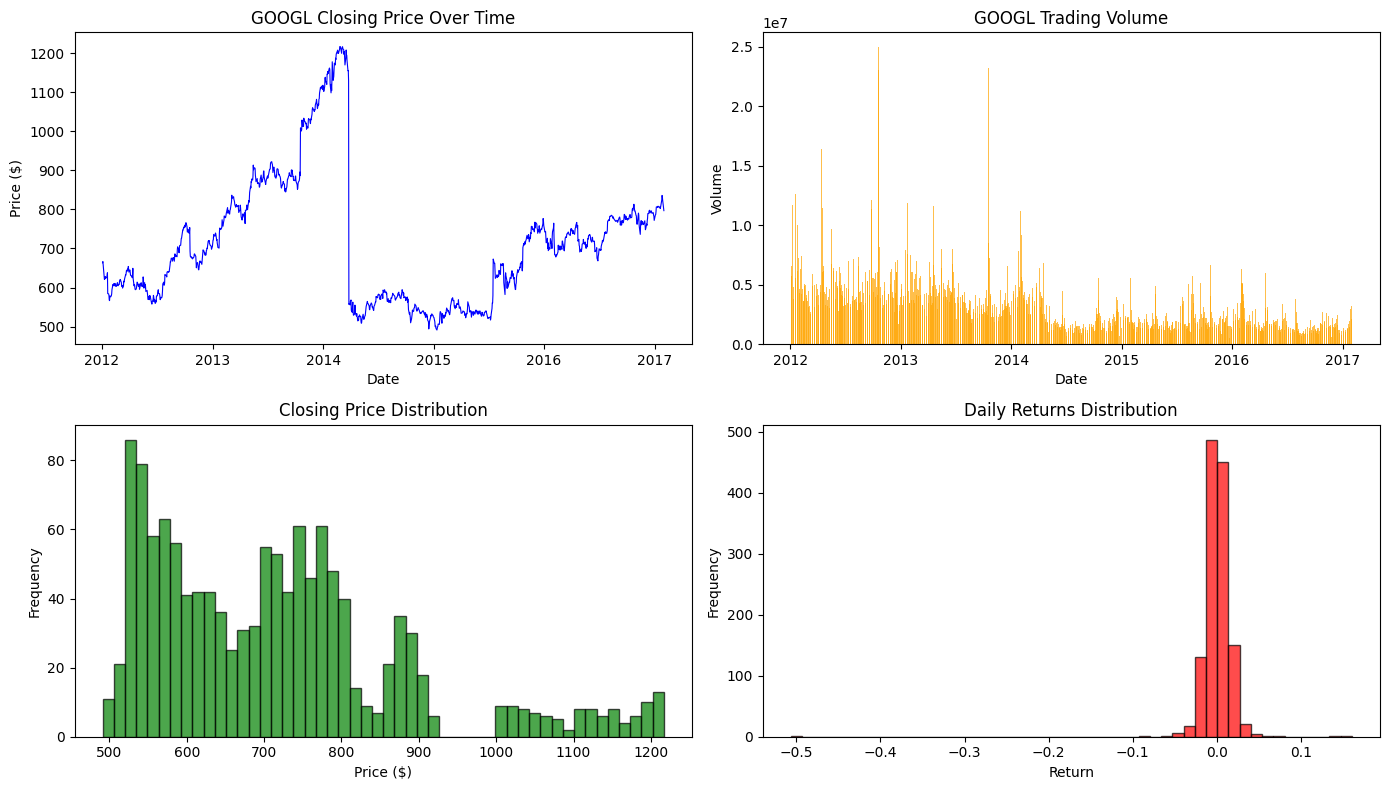

In [11]:
# ============================================================
# STEP 3: EXPLORATORY DATA ANALYSIS
# ============================================================
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Plot 1: Closing Price Over Time
axes[0, 0].plot(df.index, df['Close'], color='blue', linewidth=0.8)
axes[0, 0].set_title(f'{ticker} Closing Price Over Time')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Price ($)')

# Plot 2: Volume Over Time
axes[0, 1].bar(df.index, df['Volume'], color='orange', alpha=0.7, width=2)
axes[0, 1].set_title(f'{ticker} Trading Volume')
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('Volume')

# Plot 3: Price Distribution
axes[1, 0].hist(df['Close'], bins=50, color='green', edgecolor='black', alpha=0.7)
axes[1, 0].set_title('Closing Price Distribution')
axes[1, 0].set_xlabel('Price ($)')
axes[1, 0].set_ylabel('Frequency')

# Plot 4: Daily Returns
df['Returns'] = df['Close'].pct_change()
axes[1, 1].hist(df['Returns'].dropna(), bins=50, color='red', edgecolor='black', alpha=0.7)
axes[1, 1].set_title('Daily Returns Distribution')
axes[1, 1].set_xlabel('Return')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## Step 4: Data Preprocessing

In [12]:
# ============================================================
# STEP 4: DATA PREPROCESSING
# ============================================================

# We'll predict 'Close' price using historical 'Close' prices
# Use only the 'Close' column
data = df[['Close']].values

print(f"Original data shape: {data.shape}")

# Scale data to [0, 1] range - CRITICAL for neural networks!
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

print(f"Scaled data range: [{data_scaled.min():.4f}, {data_scaled.max():.4f}]")

Original data shape: (1278, 1)
Scaled data range: [0.0000, 1.0000]


In [13]:
# ============================================================
# CREATE SEQUENCES FOR LSTM
# ============================================================
# LSTM needs sequences: use past N days to predict next day

def create_sequences(data, seq_length):
    """
    Create sequences for LSTM training.
    
    Args:
        data: Scaled price data
        seq_length: Number of past days to use for prediction
    
    Returns:
        X: Input sequences (batch, seq_length, features)
        y: Target values (next day's price)
    """
    X, y = [], []
    for i in range(len(data) - seq_length):
        # Input: past seq_length days
        X.append(data[i:(i + seq_length), 0])
        # Target: next day's price
        y.append(data[i + seq_length, 0])
    return np.array(X), np.array(y)

# Hyperparameter: sequence length (look-back period)
SEQUENCE_LENGTH = 60  # Use past 60 days to predict next day

X, y = create_sequences(data_scaled, SEQUENCE_LENGTH)

print(f"\nSequence shape X: {X.shape}")  # (samples, sequence_length)
print(f"Target shape y: {y.shape}")      # (samples,)

# Reshape X to (samples, sequence_length, features) for LSTM
X = X.reshape((X.shape[0], X.shape[1], 1))
print(f"Reshaped X for LSTM: {X.shape}")


Sequence shape X: (1218, 60)
Target shape y: (1218,)
Reshaped X for LSTM: (1218, 60, 1)


## Step 5: Train / Validation / Test Split

In [ ]:
# ============================================================
# STEP 5: TRAIN / VALIDATION / TEST SPLIT
# ============================================================

# Time-series split: must be chronological (no shuffling!)
train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.15)
test_size = len(X) - train_size - val_size

X_train = X[:train_size]
y_train = y[:train_size]

X_val = X[train_size:train_size + val_size]
y_val = y[train_size:train_size + val_size]

X_test = X[train_size + val_size:]
y_test = y[train_size + val_size:]

print(f"Training set:   {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set:       {X_test.shape[0]} samples")

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train).to(device)
y_train_tensor = torch.FloatTensor(y_train).to(device)
X_val_tensor = torch.FloatTensor(X_val).to(device)
y_val_tensor = torch.FloatTensor(y_val).to(device)
X_test_tensor = torch.FloatTensor(X_test).to(device)
y_test_tensor = torch.FloatTensor(y_test).to(device)

# Create DataLoaders
BATCH_SIZE = 32

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)  # No shuffle for time-series!

val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"\nDataLoaders created with batch size: {BATCH_SIZE}")

## Step 6: LSTM Model Architecture

### LSTM Internal Structure
Each LSTM cell contains **4 parallel neural networks** (gates):

| Gate | Formula | Activation | Purpose |
|------|---------|------------|--------|
| **Forget** | $f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f)$ | Sigmoid | How much old memory to keep |
| **Input** | $i_t = \sigma(W_i \cdot [h_{t-1}, x_t] + b_i)$ | Sigmoid | How much new info to add |
| **Candidate** | $\tilde{C}_t = \tanh(W_C \cdot [h_{t-1}, x_t] + b_C)$ | Tanh | What new info to add |
| **Output** | $o_t = \sigma(W_o \cdot [h_{t-1}, x_t] + b_o)$ | Sigmoid | How much memory to expose |

**Cell State Update:** $C_t = f_t \odot C_{t-1} + i_t \odot \tilde{C}_t$

**Hidden State Update:** $h_t = o_t \odot \tanh(C_t)$

In [ ]:
# ============================================================
# STEP 6: LSTM MODEL ARCHITECTURE
# ============================================================

class LSTMModel(nn.Module):
    """
    LSTM for Stock Price Prediction
    
    Architecture:
    - LSTM layers: Learn temporal patterns from sequences
    - Fully Connected layers: Map LSTM output to prediction
    - Dropout: Prevent overfitting
    
    Inside LSTM (what PyTorch does for us):
    - Forget Gate:    f_t = σ(W_f · [h_{t-1}, x_t] + b_f)
    - Input Gate:     i_t = σ(W_i · [h_{t-1}, x_t] + b_i)  
    - Candidate:      C̃_t = tanh(W_C · [h_{t-1}, x_t] + b_C)
    - Cell State:     C_t = f_t ⊙ C_{t-1} + i_t ⊙ C̃_t
    - Output Gate:    o_t = σ(W_o · [h_{t-1}, x_t] + b_o)
    - Hidden State:   h_t = o_t ⊙ tanh(C_t)
    """
    
    def __init__(self, input_size=1, hidden_size=50, num_layers=2, dropout=0.2):
        super(LSTMModel, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM Layer
        # input_size: number of features (1 for univariate)
        # hidden_size: number of LSTM units (neurons)
        # num_layers: stacked LSTM layers
        # batch_first: input shape is (batch, seq, features)
        # dropout: dropout between LSTM layers
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        # Fully Connected layers to produce final prediction
        self.fc1 = nn.Linear(hidden_size, 25)
        self.fc2 = nn.Linear(25, 1)
        
        # Activation and Dropout
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        """
        Forward pass through the network.
        
        Args:
            x: Input tensor of shape (batch_size, sequence_length, input_size)
        
        Returns:
            out: Predictions of shape (batch_size, 1)
        """
        # Initialize hidden state and cell state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate through LSTM
        # lstm_out shape: (batch_size, sequence_length, hidden_size)
        # h_n shape: (num_layers, batch_size, hidden_size) - final hidden state
        # c_n shape: (num_layers, batch_size, hidden_size) - final cell state
        lstm_out, (h_n, c_n) = self.lstm(x, (h0, c0))
        
        # We only need the output from the last time step
        # lstm_out[:, -1, :] shape: (batch_size, hidden_size)
        last_output = lstm_out[:, -1, :]
        
        # Pass through fully connected layers
        out = self.fc1(last_output)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        
        return out

# Instantiate model
model = LSTMModel(
    input_size=1,      # 1 feature (Close price)
    hidden_size=50,    # 50 LSTM units
    num_layers=2,      # 2 stacked LSTM layers
    dropout=0.2        # 20% dropout
).to(device)

print(model)
print(f"\nTotal Parameters: {sum(p.numel() for p in model.parameters()):,}")

## Step 7: Training Setup

In [ ]:
# ============================================================
# STEP 7: TRAINING SETUP
# ============================================================

# Loss function: Mean Squared Error (for regression)
criterion = nn.MSELoss()

# Optimizer: Adam with learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Learning rate scheduler: reduce LR when validation loss plateaus
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5, verbose=True
)

# Training parameters
NUM_EPOCHS = 100
EARLY_STOP_PATIENCE = 15

print("Training Configuration:")
print(f"  - Loss Function: MSELoss")
print(f"  - Optimizer: Adam (lr=0.001)")
print(f"  - Max Epochs: {NUM_EPOCHS}")
print(f"  - Early Stopping Patience: {EARLY_STOP_PATIENCE}")

## Step 8: Training Loop

In [ ]:
# ============================================================
# STEP 8: TRAINING LOOP
# ============================================================

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, 
                num_epochs, patience):
    """
    Training loop with validation and early stopping.
    """
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    
    for epoch in range(num_epochs):
        # ================== TRAINING ==================
        model.train()
        train_loss = 0.0
        
        for X_batch, y_batch in train_loader:
            # Forward pass
            predictions = model(X_batch)
            loss = criterion(predictions.squeeze(), y_batch)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            
            # Gradient clipping (prevent exploding gradients)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        # ================== VALIDATION ==================
        model.eval()
        val_loss = 0.0
        
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                predictions = model(X_batch)
                loss = criterion(predictions.squeeze(), y_batch)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        
        # Learning rate scheduler step
        scheduler.step(val_loss)
        
        # ================== EARLY STOPPING ==================
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
        
        # Print progress every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] | "
                  f"Train Loss: {train_loss:.6f} | "
                  f"Val Loss: {val_loss:.6f} | "
                  f"LR: {optimizer.param_groups[0]['lr']:.6f}")
        
        # Early stopping
        if patience_counter >= patience:
            print(f"\nEarly stopping at epoch {epoch+1}")
            break
    
    # Load best model
    model.load_state_dict(best_model_state)
    
    return train_losses, val_losses

# Train the model!
print("Starting training...\n")
train_losses, val_losses = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler,
    NUM_EPOCHS, EARLY_STOP_PATIENCE
)
print("\nTraining complete!")

## Step 9: Learning Curves Visualization

In [ ]:
# ============================================================
# STEP 9: LEARNING CURVES
# ============================================================

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.title('LSTM Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Final Training Loss: {train_losses[-1]:.6f}")
print(f"Final Validation Loss: {val_losses[-1]:.6f}")

## Step 10: Evaluation on Test Set

In [ ]:
# ============================================================
# STEP 10: EVALUATION
# ============================================================

model.eval()

with torch.no_grad():
    # Get predictions
    y_pred_scaled = model(X_test_tensor).cpu().numpy()
    y_test_actual = y_test_tensor.cpu().numpy()

# Inverse transform to get actual prices
y_pred = scaler.inverse_transform(y_pred_scaled)
y_actual = scaler.inverse_transform(y_test_actual.reshape(-1, 1))

# Calculate metrics
mae = mean_absolute_error(y_actual, y_pred)
rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
r2 = r2_score(y_actual, y_pred)

print("=" * 50)
print("TEST SET EVALUATION METRICS")
print("=" * 50)
print(f"Mean Absolute Error (MAE):  ${mae:.2f}")
print(f"Root Mean Squared Error:    ${rmse:.2f}")
print(f"R² Score:                   {r2:.4f}")
print("=" * 50)

## Step 11: Baseline Model Comparison

In [ ]:
# ============================================================
# STEP 11: BASELINE MODEL COMPARISON
# ============================================================
# Simple baseline: Predict tomorrow's price = today's price (Naive Persistence)

# Baseline predictions: shift by 1
y_baseline = scaler.inverse_transform(
    y_test[:-1].reshape(-1, 1)  # Previous day's actual price
)
y_actual_baseline = scaler.inverse_transform(
    y_test[1:].reshape(-1, 1)   # Today's actual price
)

baseline_mae = mean_absolute_error(y_actual_baseline, y_baseline)
baseline_rmse = np.sqrt(mean_squared_error(y_actual_baseline, y_baseline))
baseline_r2 = r2_score(y_actual_baseline, y_baseline)

print("\n" + "=" * 50)
print("BASELINE MODEL (Naive Persistence)")
print("=" * 50)
print(f"Baseline MAE:   ${baseline_mae:.2f}")
print(f"Baseline RMSE:  ${baseline_rmse:.2f}")
print(f"Baseline R²:    {baseline_r2:.4f}")
print("=" * 50)

print(f"\n📊 LSTM Improvement over Baseline:")
print(f"   MAE Improvement:  {((baseline_mae - mae) / baseline_mae) * 100:.1f}%")
print(f"   RMSE Improvement: {((baseline_rmse - rmse) / baseline_rmse) * 100:.1f}%")

## Step 12: Prediction Visualization

In [ ]:
# ============================================================
# STEP 12: PREDICTION VISUALIZATION
# ============================================================

plt.figure(figsize=(14, 6))

# Plot actual vs predicted
plt.plot(y_actual, label='Actual Price', color='blue', linewidth=1.5)
plt.plot(y_pred, label='LSTM Predicted', color='red', linewidth=1.5, alpha=0.8)

plt.title(f'{ticker} Stock Price Prediction - LSTM Model')
plt.xlabel('Time Steps (Test Period)')
plt.ylabel('Stock Price ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# ============================================================
# RESIDUAL ANALYSIS
# ============================================================

residuals = y_actual.flatten() - y_pred.flatten()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Residual Plot
axes[0].scatter(y_pred.flatten(), residuals, alpha=0.5, edgecolors='k', linewidths=0.5)
axes[0].axhline(y=0, color='red', linestyle='--')
axes[0].set_xlabel('Predicted Price ($)')
axes[0].set_ylabel('Residual ($)')
axes[0].set_title('Residual Plot')

# Residual Distribution
axes[1].hist(residuals, bins=30, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Residual ($)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Residual Distribution')

plt.tight_layout()
plt.show()

print(f"Mean Residual: ${residuals.mean():.2f}")
print(f"Std Residual:  ${residuals.std():.2f}")

## Step 13: Save Model

In [ ]:
# ============================================================
# STEP 13: SAVE MODEL
# ============================================================

# Save the trained model
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses,
    'val_losses': val_losses,
    'scaler': scaler,
    'hyperparameters': {
        'sequence_length': SEQUENCE_LENGTH,
        'hidden_size': 50,
        'num_layers': 2,
        'dropout': 0.2
    }
}, 'models/lstm_stock_model.pth')

print("✅ Model saved to 'models/lstm_stock_model.pth'")

## Summary

### Model Performance
| Metric | LSTM | Baseline (Naive) |
|--------|------|------------------|
| MAE | ${mae:.2f} | ${baseline_mae:.2f} |
| RMSE | ${rmse:.2f} | ${baseline_rmse:.2f} |
| R² | {r2:.4f} | {baseline_r2:.4f} |

### Key Takeaways
1. **LSTM captures temporal patterns** in stock prices effectively
2. **Sequence length of 60 days** provides sufficient historical context
3. **2-layer stacked LSTM** with 50 hidden units balances capacity and overfitting
4. **Early stopping** prevents overfitting and saves training time

### Limitations
- Stock prices are influenced by external factors (news, events) not captured by historical prices alone
- Model predicts based on patterns; cannot predict black swan events
- Single feature (Close price) limits the model's information